# Import libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load data

In [55]:
df = pd.read_csv('df_model.csv', parse_dates=['Adjusted_Date'])

df_split = df[df['Adjusted_Date'] < '2020-01-01']
df_split.reset_index(drop=True, inplace=True)

# Split data into in-sample and out-of-sample sets
train_set = df_split[df_split['Adjusted_Date'] < '2019-09-01']
test_set = df_split[df_split['Adjusted_Date'] >= '2019-09-01']

# Separate features and target variable
X_train = train_set.drop(columns=['PSEI_Close'])
y_train = train_set['PSEI_Close']
X_test = test_set.drop(columns=['PSEI_Close'])
y_test = test_set['PSEI_Close']

# Define forecast error measure

In [56]:
# Define forecast error measure
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define variable set

In [57]:
# Sentiment columns sets (example)
column_sets = [
    ['negative_score_mean', 'neutral_score_mean', 'positive_score_mean'],
    ['negative_score_sd', 'neutral_score_sd', 'positive_score_sd'],
    ['negative_score_min', 'neutral_score_min', 'positive_score_min'],
    ['negative_score_max', 'neutral_score_max', 'positive_score_max']
]

# No neutral scores
column_sets_no_neutral = [
    ['negative_score_mean', 'positive_score_mean'],
    ['negative_score_sd', 'positive_score_sd'],
    ['negative_score_min', 'positive_score_min'],
    ['negative_score_max', 'positive_score_max']
]

# Linear regression

## Trend model

In [58]:
# Set up for linear regression modeling
results = []
results_coef = []

time_train = np.arange(len(y_train)).reshape(-1,1)
time_test = np.arange(len(y_test)).reshape(-1,1)

for cols in column_sets:
    key = 'reg_trend: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols].copy()
    X_train_cols['time_index'] = time_train
    X_test_cols = X_test[cols].copy()
    X_test_cols['time_index'] = time_test
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- Baseline model: intercept + time index -----
X_baseline_train = sm.add_constant(time_train)
X_baseline_test = sm.add_constant(time_test)

model_baseline = sm.OLS(y_train, X_baseline_train).fit()
y_train_pred_baseline = model_baseline.predict(X_baseline_train)
y_test_pred_baseline = model_baseline.predict(X_baseline_test)

results.append({
    "model": "reg: baseline_trend",
    "coef": model_baseline.params.to_dict(),
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})


In [59]:
# Initialize results list
results_noneutral = []

for cols in column_sets_no_neutral:
    key = 'reg_trend: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols].copy()
    X_train_cols['time_index'] = time_train
    X_test_cols = X_test[cols].copy()
    X_test_cols['time_index'] = time_test
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- Baseline model: intercept + time index -----
X_baseline_train = sm.add_constant(time_train)
X_baseline_test = sm.add_constant(time_test)

model_baseline = sm.OLS(y_train, X_baseline_train).fit()
y_train_pred_baseline = model_baseline.predict(X_baseline_train)
y_test_pred_baseline = model_baseline.predict(X_baseline_test)

results_noneutral.append({
    "model": "reg: baseline_trend",
    "coef": model_baseline.params.to_dict(),
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})

## Non-trend

In [60]:
# Set up for linear regression modeling

for cols in column_sets:
    key = 'reg: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

In [61]:
# Initialize results list

for cols in column_sets_no_neutral:
    key = 'reg: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ARIMA

## Identify AR term

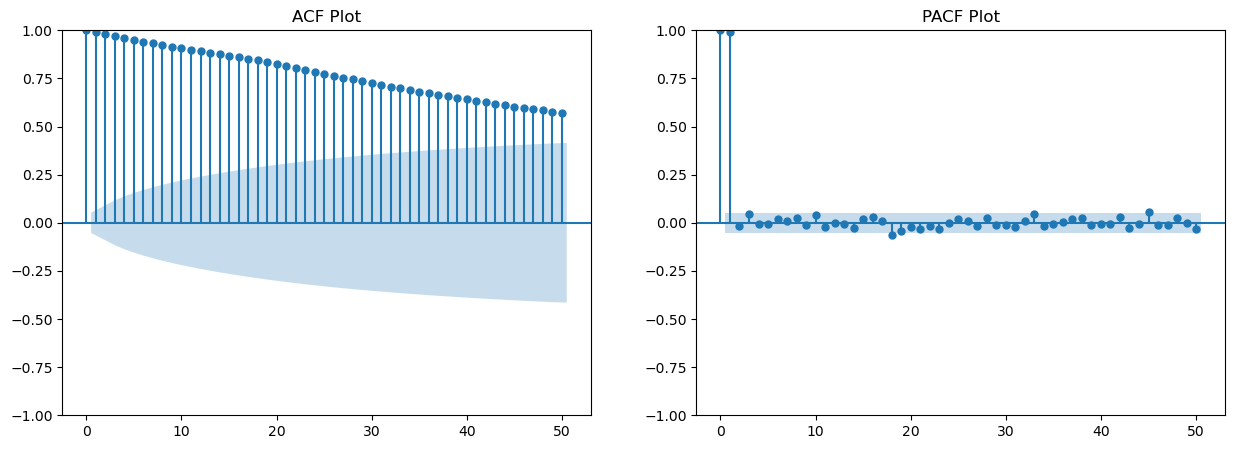

In [62]:
# Locate ideal AR term using ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF plot
plot_acf(y_train, lags=50, ax=axes[0])
axes[0].set_title('ACF Plot')

# PACF plot
plot_pacf(y_train, lags=50, ax=axes[1])
axes[1].set_title('PACF Plot')

plt.show()

## Idenitfy differencing term

In [63]:
result_adf = adfuller(df['PSEI_Close'])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

ADF Statistic: -2.84475892902403
p-value: 0.052159224685149705


In [64]:
df['PSEI_diff1'] = df['PSEI_Close'].diff().dropna()
result_adf2 = adfuller(df['PSEI_diff1'].dropna())
print('ADF Statistic after 1st difference:', result_adf2[0])
print('p-value:', result_adf2[1])


ADF Statistic after 1st difference: -25.01663206472803
p-value: 0.0


## Modeling ARIMA (2,1,1)

In [65]:
# ARIMA order
arima_order = (2,1,1)   

for cols in column_sets:
    key = 'ARIMA: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Fit model
    model_arima = ARIMA(endog=y_train_vals, exog=X_train_cols, order=arima_order)
    model = model_arima.fit()

    # Predictions
    y_train_pred = model.predict(start=0, end=len(y_train_vals)-1, exog=X_train_cols)
    y_test_pred = model.get_forecast(steps=len(y_test_vals), exog=X_test_cols).predicted_mean

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": model.params,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- ARIMA Baseline model -----
model_baseline = ARIMA(endog=y_train, order=arima_order).fit()
y_train_pred_baseline = model_baseline.predict(start=0, end=len(y_train)-1)
y_test_pred_baseline = model_baseline.get_forecast(steps=len(y_test)).predicted_mean

results.append({
    "model": "ARIMA: base",
    "coef": model_baseline.params,
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})

In [66]:
# ARIMA order
arima_order = (2,1,1)   

for cols in column_sets_no_neutral:
    key = 'ARIMA: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Fit model
    model_arima = ARIMA(endog=y_train_vals, exog=X_train_cols, order=arima_order)
    model = model_arima.fit()

    # Predictions
    y_train_pred = model.predict(start=0, end=len(y_train_vals)-1, exog=X_train_cols)
    y_test_pred = model.get_forecast(steps=len(y_test_vals), exog=X_test_cols).predicted_mean

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": model.params,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- ARIMA Baseline model -----
model_baseline = ARIMA(endog=y_train, order=arima_order).fit()
y_train_pred_baseline = model_baseline.predict(start=0, end=len(y_train)-1)
y_test_pred_baseline = model_baseline.get_forecast(steps=len(y_test)).predicted_mean

results_noneutral.append({
    "model": "ARIMA: base",
    "coef": model_baseline.params,
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})

# LSTM

In [67]:
# Develop LSTM models
for cols in column_sets:
    key = 'LSTM: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train.values
    y_test_vals = y_test.values

    # Reshape input to be 3D [samples, timesteps, features]
    X_train_reshaped = X_train_cols.values.reshape((X_train_cols.shape[0], X_train_cols.shape[1], 1))
    X_test_reshaped = X_test_cols.values.reshape((X_test_cols.shape[0], X_test_cols.shape[1], 1))

    # Fit model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_cols.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_reshaped, y_train_vals, epochs=50, batch_size=32, verbose=0)

    # Predictions - flatten to 1D
    y_train_pred = model.predict(X_train_reshaped, verbose=0).flatten()
    y_test_pred = model.predict(X_test_reshaped, verbose=0).flatten()

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": None,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display results
display(results_df)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

,model,coef,mse_train,rmse_train,mae_train,mape_train,mse_test,rmse_test,mae_test,mape_test
0,"reg_trend: negative_score_mean, neutral_score_...","{'const': 7239.1016798843475, 'negative_score_...",207066.841435,455.045977,366.738301,4.947695,957174.385742,978.352894,970.813278,12.331471
1,"reg_trend: negative_score_sd, neutral_score_sd...","{'const': 7134.62443888754, 'negative_score_sd...",208435.295967,456.547145,367.307004,4.956025,926733.080012,962.669767,954.921327,12.128416
2,"reg_trend: negative_score_min, neutral_score_m...","{'const': 6885.045192117949, 'negative_score_m...",210701.825748,459.022685,370.272698,4.996163,904986.098588,951.307573,944.133867,11.990565
3,"reg_trend: negative_score_max, neutral_score_m...","{'const': 7159.100179801185, 'negative_score_m...",209720.429355,457.952431,368.987874,4.977909,927997.558676,963.326299,956.097109,12.142708
4,reg: baseline_trend,"{'const': 6882.355217964308, 'x1': 0.871364347...",210720.770329,459.043321,370.254533,4.995837,905495.566258,951.575308,944.405551,11.994026
5,"reg: negative_score_mean, neutral_score_mean, ...","{'const': 7595.878649437836, 'negative_score_m...",315396.498550,561.601726,453.577395,6.174905,144587.776897,380.246995,347.668300,4.404235
6,"reg: negative_score_sd, neutral_score_sd, posi...","{'const': 7733.569276866736, 'negative_score_s...",320126.554136,565.797273,457.766680,6.232204,146196.222670,382.356146,356.117784,4.512193
7,"reg: negative_score_min, neutral_score_min, po...","{'const': 7519.60741582056, 'negative_score_mi...",327894.736579,572.620936,465.585672,6.336006,159246.840703,399.057440,382.063360,4.840806
8,"reg: negative_score_max, neutral_score_max, po...","{'const': 7365.598299422722, 'negative_score_m...",329298.000225,573.844927,466.002621,6.342125,152383.724657,390.363580,374.397088,4.743830
9,"ARIMA: negative_score_mean, neutral_score_mean...",negative_score_mean -30.826018 neutral_sco...,31135.725340,176.453182,58.612516,0.802469,23234.888007,152.429945,122.181427,1.569068


In [68]:
# Develop LSTM models
for cols in column_sets_no_neutral:
    key = 'LSTM: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train.values
    y_test_vals = y_test.values

    # Reshape input to be 3D [samples, timesteps, features]
    X_train_reshaped = X_train_cols.values.reshape((X_train_cols.shape[0], X_train_cols.shape[1], 1))
    X_test_reshaped = X_test_cols.values.reshape((X_test_cols.shape[0], X_test_cols.shape[1], 1))

    # Fit model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_cols.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_reshaped, y_train_vals, epochs=50, batch_size=32, verbose=0)

    # Predictions - flatten to 1D
    y_train_pred = model.predict(X_train_reshaped, verbose=0).flatten()
    y_test_pred = model.predict(X_test_reshaped, verbose=0).flatten()

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": None,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# Convert to DataFrame
results_df_noneutral = pd.DataFrame(results_noneutral)

# Display results
display(results_df_noneutral)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

,model,coef,mse_train,rmse_train,mae_train,mape_train,mse_test,rmse_test,mae_test,mape_test
0,"reg_trend: negative_score_mean, positive_score...","{'const': 6828.75173996756, 'negative_score_me...",208524.478904,456.644806,367.934142,4.964714,905263.859972,951.453551,943.897345,11.988844
1,"reg_trend: negative_score_sd, positive_score_sd","{'const': 7053.427921873887, 'negative_score_s...",209459.701018,457.667675,369.080462,4.981464,883414.175905,939.901152,932.345384,11.841296
2,"reg_trend: negative_score_min, positive_score_min","{'const': 6885.013401733777, 'negative_score_m...",210701.862006,459.022725,370.271574,4.996150,904984.042465,951.306492,944.132259,11.990544
3,"reg_trend: negative_score_max, positive_score_max","{'const': 7097.936898791259, 'negative_score_m...",210194.554850,458.469797,369.847146,4.990627,908017.831665,952.899697,945.667305,12.010246
4,reg: baseline_trend,"{'const': 6882.355217964308, 'x1': 0.871364347...",210720.770329,459.043321,370.254533,4.995837,905495.566258,951.575308,944.405551,11.994026
5,"reg: negative_score_mean, positive_score_mean","{'const': 8026.875430507894, 'negative_score_m...",316852.318632,562.896366,454.587404,6.188861,149307.542047,386.403341,358.077937,4.536814
6,"reg: negative_score_sd, positive_score_sd","{'const': 7910.2173157318475, 'negative_score_...",323353.721506,568.641998,460.093325,6.262811,154258.945075,392.758125,370.217553,4.691482
7,"reg: negative_score_min, positive_score_min","{'const': 7519.068366952303, 'negative_score_m...",327907.946302,572.632471,465.538844,6.335401,159172.300218,398.964034,381.972616,4.839634
8,"reg: negative_score_max, positive_score_max","{'const': 7447.293885325337, 'negative_score_m...",330078.451945,574.524544,467.241480,6.358009,157299.572494,396.610101,381.130861,4.829222
9,"ARIMA: negative_score_mean, positive_score_mean",negative_score_mean -32.270042 positive_sc...,31151.352254,176.497457,58.609502,0.802435,23228.318533,152.408394,122.157571,1.568764


# Export results

In [69]:
# Export results
results_df.to_csv('modeling_results_bCOVID.csv', index=False)
results_df_noneutral.to_csv('modeling_results_noneutral_bCOVID.csv', index=False)